<a href="https://colab.research.google.com/github/KeisukeShimokawa/papers-challenge/blob/master/src/gan/DCGAN/notebooks/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## session timeout

In [1]:
%%writefile access_colab.sh

#!/bin/bash

for i in `seq 0 12`
do
  echo "[$i]" ` date '+%y/%m/%d %H:%M:%S'` "connected."
  open <<自分のノートブックのURL>>
  sleep 3600
done

Writing access_colab.sh


In [0]:
!chmod 755 access_colab.sh

In [3]:
!./access_colab.sh

./access_colab.sh: line 9: warning: here-document at line 7 delimited by end-of-file (wanted `自分のノートブックのURL')
./access_colab.sh: line 9: syntax error near unexpected token `newline'
./access_colab.sh: line 9: `  open <<自分のノートブックのURL>>'


## download

In [0]:
!rm -rf *.txt
!rm -rf logs

In [5]:
!nvidia-smi | head -n 10

Tue May 19 13:02:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+


In [0]:
!mkdir -p data
!wget -q https://www.dropbox.com/s/j6tp062e14gg5yc/img_align_celeba.zip -O data/celeba.zip
!unzip -q -o -d ./data data/celeba.zip
!rm -rf data/celeba.zip

In [7]:
!ls data

img_align_celeba


In [0]:
import os
import sys
import time
import random
import logging
import dataclasses
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Function, Variable
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from torchsummary import summary

In [0]:
class Logger:
    def __init__(self, log_dir, flush_secs):

        self.log_dir = Path(log_dir)
        self.flush_secs = flush_secs
        self.logger = self._build_logger()
        self.writers = {}

    def _build_logger(self):
        logger = logging.getLogger(str(self.log_dir))
        logger.setLevel(logging.INFO)
        # format
        fmt_str = "[%(levelname)s] %(asctime)s: \t%(message)s"
        fmt = logging.Formatter(fmt_str, "%Y-%m-%d %H-%M-%S")
        # stream handler
        stm_handler = logging.StreamHandler(sys.stdout)
        stm_handler.setLevel(logging.INFO)
        stm_handler.setFormatter(fmt)
        # file handler
        file_handler = logging.FileHandler("training_log.txt")
        file_handler.setLevel(logging.INFO)
        file_handler.setFormatter(fmt)
        # add handler to logger
        logger.addHandler(stm_handler)
        logger.addHandler(file_handler)

        return logger

    def print_log(self, message):
        self.logger.info(message)

    def _build_writer(self, metrics):
        writer = SummaryWriter(
            log_dir=self.log_dir.joinpath("data", metrics),
            flush_secs=self.flush_secs
        )
        return writer

    def write_summaries(self, metrics, value, global_step=None):
        if metrics not in self.writers:
            self.writers[metrics] = self._build_writer(metrics)

        self.writers[metrics].add_scalar(metrics, value, global_step)

    def add_image_summaries(self, tag, tensor, global_step=None):
        n = min(tensor.size(0), 36)
        image_tensor = make_grid(tensor[:n], nrow=6, padding=2, normalize=True)

        if tag not in self.writers:
            self.writers[tag] = self._build_writer(tag)

        self.writers[tag].add_image(tag, image_tensor, global_step)

    def close_writers(self):
        for metrics in self.writers:
            self.writers[metrics].close()

## configuration

In [0]:
@dataclasses.dataclass
class Config:
    # general settings
    seed: int = 42
    ngpu: int = 1
    
    # dataset
    datapath: str = "data/"
    num_workers: int = 2
    image_size: int = 64

    # model
    nc: int = 3
    nz: int = 100
    ngf: int = 64
    ndf: int = 64
    use_sn: bool = True
    use_cbm: bool = True

    # training
    n_epochs: int = 20
    batch_size: int = 128
    beta1: float = 0.
    lrD: float = 1e-4
    lrG: float = 1e-4
    is_ortho: bool = True
    factor: float = 1e-5

    # logging
    log_dir: str = "logs"
    flush_secs: int = 5

In [0]:
# set configuraition
cfg = Config()

In [12]:
logger = Logger(cfg.log_dir, cfg.flush_secs)

logger.print_log(f"configuration: {cfg}")

[INFO] 2020-05-19 13-03-47: 	configuration: Config(seed=42, ngpu=1, datapath='data/', num_workers=2, image_size=64, nc=3, nz=100, ngf=64, ndf=64, use_sn=True, use_cbm=True, n_epochs=20, batch_size=128, beta1=0.0, lrD=0.0001, lrG=0.0001, is_ortho=True, factor=1e-05, log_dir='logs', flush_secs=5)


In [0]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [14]:
if cfg.seed:
    set_seed(cfg.seed)
    logger.print_log(f"set random seed: {cfg.seed}")

[INFO] 2020-05-19 13-03-47: 	set random seed: 42


In [15]:
is_cuda = cfg.ngpu > 0 and torch.cuda.is_available()
device = torch.device("cuda:0" if is_cuda else "cpu")

logger.print_log(f"device setting: {device}")

[INFO] 2020-05-19 13-03-47: 	device setting: cuda:0


## dataset

In [16]:
dataset = datasets.ImageFolder(
    root=cfg.datapath,
    transform=transforms.Compose([
        transforms.Resize(cfg.image_size),
        transforms.CenterCrop(cfg.image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)

dataloader = DataLoader(
    dataset, 
    batch_size=cfg.batch_size,
    shuffle=True, 
    num_workers=cfg.num_workers
)

logger.print_log(f"dataset size: {len(dataset)}")

[INFO] 2020-05-19 13-03-47: 	dataset size: 202599


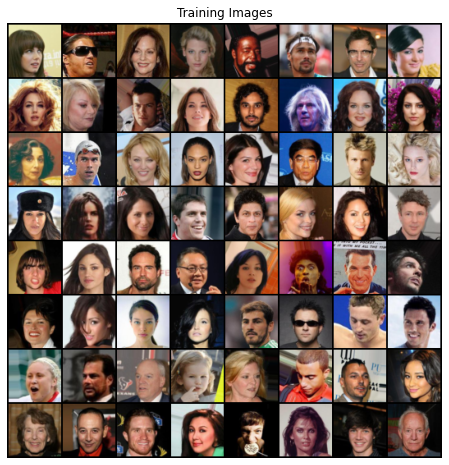

In [17]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    np.transpose(
        make_grid(real_batch[0].to(device)[:64], normalize=True).cpu(),
        (1,2,0)
    )
)

In [18]:
logger.print_log(f"sample real batch size: {real_batch[0].size()}")
logger.add_image_summaries("sample", real_batch[0])

[INFO] 2020-05-19 13-03-58: 	sample real batch size: torch.Size([128, 3, 64, 64])


## model

In [0]:
def SNConv2d(*args, **kwargs):
    return torch.nn.utils.spectral_norm(nn.Conv2d(*args, **kwargs))

In [0]:
def SNLinear(*args, **kwargs):
    return torch.nn.utils.spectral_norm(nn.Linear(*args, **kwargs))

In [0]:
def SNEmbedding(*args, **kwargs):
    return torch.nn.utils.spectral_norm(nn.Embedding(*args, **kwargs))

In [0]:
class ConditionalBatchNorm2d(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.num_features = num_features
        self.bn = nn.BatchNorm2d(num_features, affine=False)
        self.embed = nn.Embedding(num_classes, num_features * 2)
        self.embed.weight_data[:, :num_features].normal_(1, 0.02)
        self.embed.weight_data[:, num_features:].zero_()

    def forward(self, x, y):
        out = self.bn(x)
        gamma, beta = self.embed(y).chunk(2, 1)
        out = gamma.view(-1, self.num_features, 1, 1) * out + \
               beta.view(-1, self.num_features, 1, 1)

        return out

In [0]:
def SNConvTranspose2d(*args, **kwargs):
    return torch.nn.utils.spectral_norm(nn.ConvTranspose2d(*args, **kwargs))

In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
class Generator(nn.Module):
    def __init__(self, ngpu, nz, ngf, nc, use_sn=False):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False) 
            if not use_sn else SNConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False)
            if not use_sn else SNConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False)
            if not use_sn else SNConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False)
            if not use_sn else SNConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False)
            if not use_sn else SNConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [26]:
# Create the generator
netG = Generator(cfg.ngpu, cfg.nz, cfg.ngf, cfg.nc, cfg.use_sn).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (cfg.ngpu > 1):
    netG = nn.DataParallel(netG, list(range(cfg.ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

summary(netG, (cfg.nz, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

In [0]:
class Discriminator(nn.Module):
    def __init__(self, ngpu, nc, ndf, use_sn=False):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)
            if not use_sn else SNConv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)
            if not use_sn else SNConv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)
            if not use_sn else SNConv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)
            if not use_sn else SNConv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)
            if not use_sn else SNConv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [28]:
# Create the Discriminator
netD = Discriminator(cfg.ngpu, cfg.nc, cfg.ndf, cfg.use_sn).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (cfg.ngpu > 1):
    netD = nn.DataParallel(netD, list(range(cfg.ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
summary(netD, (cfg.nc, cfg.image_size, cfg.image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,192
          Sigmoid-13              [-1, 1, 1, 1]               0
Total params: 2,765,568
Trainable param

## training settings

In [29]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, cfg.nz, 1, 1, device=device)
logger.print_log(f"fixed noise shape: {fixed_noise.size()}")

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=cfg.lrD, betas=(cfg.beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=cfg.lrG, betas=(cfg.beta1, 0.999))

[INFO] 2020-05-19 13-04-06: 	fixed noise shape: torch.Size([64, 100, 1, 1])


In [0]:
def orthogonal_regularization(model, factor=1e-4, device=None):
    with torch.enable_grad():
        ortho_loss = torch.tensor(0., device=device)
        for name, param in model.named_parameters():
            if "bias" not in name:
                w = param.view(param.size(0), -1)
                sym = ((w @ w.t()) * (1. - torch.eye(w.size(0), device=device)))
                ortho_loss += factor * sym.abs().sum()

    return ortho_loss

## training

In [35]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [36]:
%tensorboard --logdir {cfg.log_dir}

Reusing TensorBoard on port 6006 (pid 200), started 0:03:05 ago. (Use '!kill 200' to kill it.)

<IPython.core.display.Javascript object>

In [0]:
# Lists to keep track of progress
history = {
    "img_list": [],
    "g_losses": [],
    "d_losses": []
}
iters = 0

logger.print_log("Starting Training Loop...")
# For each epoch
for epoch in range(cfg.n_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, cfg.nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        if cfg.is_ortho:
            ortho_loss = orthogonal_regularization(netG, factor=cfg.factor, device=device)
            errG += ortho_loss
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 300 == 0:
            logger.print_log('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                            % (epoch, cfg.n_epochs, i, len(dataloader),
                            errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        history["g_losses"].append(errG.item())
        history["d_losses"].append(errD.item())
        logger.write_summaries("g_losses", errG.item(), global_step=iters)
        logger.write_summaries("d_losses", errD.item(), global_step=iters)
        logger.write_summaries("ortho_losses", ortho_loss.item(), global_step=iters)

        iters += 1

    # Check how the generator is doing by saving G's output on fixed_noise
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    history["img_list"].append(make_grid(fake, padding=2, normalize=True))
    # output to tensorboard
    logger.add_image_summaries("img", fake, global_step=epoch)


[INFO] 2020-05-19 13-13-00: 	Starting Training Loop...
[INFO] 2020-05-19 13-13-01: 	[0/20][0/1583]	Loss_D: 0.0410	Loss_G: 7.9365	D(x): 0.9786	D(G(z)): 0.0184 / 0.0147
[INFO] 2020-05-19 13-13-55: 	[0/20][300/1583]	Loss_D: 1.4312	Loss_G: 13.4175	D(x): 0.9861	D(G(z)): 0.7102 / 0.0001
[INFO] 2020-05-19 13-14-50: 	[0/20][600/1583]	Loss_D: 0.3196	Loss_G: 5.6622	D(x): 0.8248	D(G(z)): 0.0990 / 0.1061
[INFO] 2020-05-19 13-15-44: 	[0/20][900/1583]	Loss_D: 0.3768	Loss_G: 5.1100	D(x): 0.7658	D(G(z)): 0.0829 / 0.1564
[INFO] 2020-05-19 13-16-37: 	[0/20][1200/1583]	Loss_D: 0.5203	Loss_G: 5.9214	D(x): 0.8822	D(G(z)): 0.3108 / 0.0594
[INFO] 2020-05-19 13-17-30: 	[0/20][1500/1583]	Loss_D: 0.4647	Loss_G: 5.2570	D(x): 0.8532	D(G(z)): 0.2531 / 0.0970
[INFO] 2020-05-19 13-17-45: 	[1/20][0/1583]	Loss_D: 0.8194	Loss_G: 3.8047	D(x): 0.5110	D(G(z)): 0.0801 / 0.3823
[INFO] 2020-05-19 13-18-36: 	[1/20][300/1583]	Loss_D: 1.4463	Loss_G: 7.8016	D(x): 0.9570	D(G(z)): 0.7246 / 0.0083
[INFO] 2020-05-19 13-19-27: 	[1/20

In [0]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(history["g_losses"],label="G")
plt.plot(history["d_losses"],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [0]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in history["img_list"]]
ani = animation.ArtistAnimation(fig, ims, interval=500, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [0]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(history["img_list"][-1],(1,2,0)))
plt.show()